In [1]:
import numpy as np
import numpy
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from time import time
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2


In [15]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import add_arg_scope
import tensorflow_hub as hub
import tensorflow_probability
tfd = tensorflow_probability.distributions
from tensorflow.contrib.opt import ScipyOptimizerInterface 
# tf.enable_eager_execution()

In [3]:
sys.path.append('../code/utils/')
sys.path.append('../code/flowpm/')
import tools
from background import *
import tfpm 
import tfpmfuncs as tfpf
from tfpmconfig import Config
from layers import wide_resnet
import datalib as dlib
import datatools as dtools


In [4]:

#############################
seed_in = 3
from numpy.random import seed
seed(seed_in)
from tensorflow import set_random_seed
set_random_seed(seed_in)

bs = 400
nc, ncf = 128, 512
ncp = 128
step, stepf = 5, 40
path = '../data/z00/'
ftype = 'L%04d_N%04d_S%04d_%02dstep/'
numd = 1e-3
num = int(numd*bs**3)
R1 = 3
R2 = 3*1.2
kny = np.pi*ncp/bs
kk = tools.fftk((ncp, ncp, ncp), bs)
seeds = [100]
rprob = 0.5
shape = (nc, nc, nc)

In [5]:
suff = 'pad2'
ftname = ['cic']
nchannels = len(ftname)


cube_size = 32
max_offset = ncp - cube_size
pad = 2
cube_sizeft = cube_size + 2*pad



In [6]:
meshes = {}
cube_features, cube_target = [], []
for seed in seeds:
    mesh = {}
    partp = tools.readbigfile(path + ftype%(bs, nc, seed, step) + 'dynamic/1/Position/')
    mesh['cic'] = tools.paintcic(partp, bs, ncp)
    mesh['decic'] = tools.decic(mesh['cic'], kk, kny)
    mesh['R1'] = tools.fingauss(mesh['cic'], kk, R1, kny)
    mesh['R2'] = tools.fingauss(mesh['cic'], kk, R2, kny)
    mesh['GD'] = mesh['R1'] - mesh['R2']
    mesh['s'] = tools.readbigfile(path + ftype%(bs, nc, seed, step) + 'mesh/s/')

    hmesh = {}
    hposall = tools.readbigfile(path + ftype%(bs, ncf, seed, stepf) + 'FOF/PeakPosition/')[1:]
    hposd = hposall[:num].copy()
    hmesh['pcic'] = tools.paintcic(hposd, bs, nc)
    hmesh['pnn'] = tools.paintnn(hposd, bs, ncp)
    hmesh['target'] = hmesh['pnn'].copy()

    print('All the mesh have been generated for seed = %d'%seed)

    #Create training voxels                                                                                                                 
    ftlist = [mesh[i].copy() for i in ftname]
    ftlistpad = [np.pad(i, pad, 'wrap') for i in ftlist]
    targetmesh = hmesh['target']
    targetmesh[targetmesh > 1] = 1

    ncube = int(ncp/cube_size)
    inp = dtools.splitvoxels(ftlistpad, cube_size=cube_sizeft, shift=cube_size, ncube=ncube)
    yinp = dtools.splitvoxels(targetmesh, cube_size=cube_size, shift=cube_size, ncube=ncube)
    mesh['inp'], mesh['yinp'] = inp, yinp
    
    meshes[seed] = [mesh, hmesh]

# features = np.stack(features, axis=0)
# target = np.stack(target, axis=0)



All the mesh have been generated for seed = 100


# Halos

In [7]:
tf.reset_default_graph()

#                                                                                                                                           
niter = 9000
sess = tf.Session()
chkname = suff #+'_it%d'%niter                                                                                                              

path_savedat = './models/n%02d/%s/%s.hub'%(numd*1e4, suff, suff)
# saver = tf.train.import_meta_graph('./../code/models/n%02d/%s/%s.meta'%(numd*1e4, suff, chkname))


In [8]:
tf.reset_default_graph()
module = hub.Module('./models/n%02d/%s/%s.hub'%(numd*1e4, suff, chkname))
xx = tf.placeholder(tf.float32, shape=[None, cube_sizeft, cube_sizeft, cube_sizeft, nchannels], name='input')
yy = tf.placeholder(tf.float32, shape=[None, cube_size, cube_size, cube_size, 1], name='labels')
output = module(dict(input=xx, label=yy, keepprob=1), as_dict=True)['prediction']

with tf.Session() as sess:
    sess.run(tf.initializers.global_variables())
        
    for seed in seeds:
        inp, yinp = meshes[seed][0]['inp'], meshes[seed][0]['yinp']
        recp = sess.run(output, feed_dict={xx:inp, yy:yinp})
        meshes[seed][0]['predict'] = dtools.uncubify(recp[:,:,:,:,0], shape)


INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
(32, 32, 32) [128 128 128]


/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


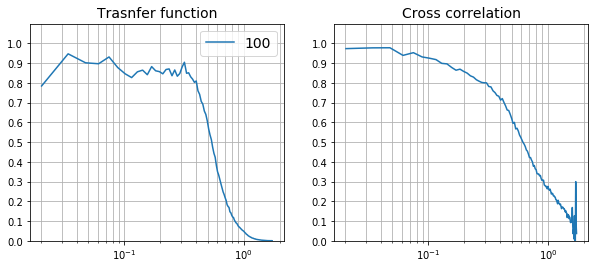

In [9]:
kk = tools.fftk(shape, bs)
kmesh = sum(i**2 for i in kk)**0.5


fig, ax = plt.subplots(1, 2, figsize = (10, 4))
for seed in seeds:
    predict, hpmeshd = meshes[seed][0]['predict'], meshes[seed][1]['target'],
    k, pkpred = tools.power(predict/predict.mean(), boxsize=bs, k=kmesh)
    k, pkhd = tools.power(hpmeshd/hpmeshd.mean(), boxsize=bs, k=kmesh)
    k, pkhx = tools.power(hpmeshd/hpmeshd.mean(), predict/predict.mean(), boxsize=bs, k=kmesh)
    #k, pkpredall = tools.power(predictall/predictall.mean(), boxsize=bs, k=kmesh)                                                          
    #k, pkhallx = tools.power(hpmeshd/hpmeshd.mean(), predictall/predictall.mean(), boxsize=bs, k=kmesh)                                    

    ##                                                                                                                                      
    ax[0].semilogx(k, pkpred/pkhd, label=seed)
    ax[1].semilogx(k, pkhx/(pkpred*pkhd)**0.5)
    # plt.plot(k, pkpredall/pkhd)                                                                                                           

ax[0].legend(fontsize=14)
ax[0].set_title('Trasnfer function', fontsize=14)
ax[1].set_title('Cross correlation', fontsize=14)
for axis in ax: axis.set_ylim(0., 1.1)
for axis in ax: axis.set_yticks(np.arange(0, 1.1, 0.1))
for axis in ax: axis.grid(which='both')


# Recon single voxel here


In [ ]:
# xopt = tf.get_variable(name='xopt', shape=[1, cube_sizeft, cube_sizeft, cube_sizeft, nchannels]
#                        , initializer=tf.random_normal_initializer(mean=5,stddev=2), trainable=True)

In [73]:
##Do optimization here
##############################                                                                                                              
##MODEL HERE
#                                                                                                                                           
####################################
#Select data voxel
ind = np.random.randint(100)
ind = 0
inp, yinp = meshes[seed][0]['inp'], meshes[seed][0]['yinp']
print('Index = %d'%ind)
recontruth = inp[ind:ind+1]
reconmapp = yinp[ind:ind+1]
####################################


losses = []
niter = 500
def call_loss(l):
    if len(losses) % (niter//10) == 0: print(l)
    losses.append(l)

    
tf.reset_default_graph()
chkname = suff #+'_it%d'%niter                                                                                                              


module = hub.Module('./models/n%02d/%s/%s.hub'%(numd*1e4, suff, chkname))

#To predict                                                                                                                                 
xx = tf.placeholder(tf.float32, shape=[None, cube_sizeft, cube_sizeft, cube_sizeft, nchannels], name='input')
yy = tf.placeholder(tf.float32, shape=[None, cube_size, cube_size, cube_size, 1], name='labels')
output = module(dict(input=xx, label=yy, keepprob=1), as_dict=True)['prediction']
#To optimize                                                                                                                       
xopt = tf.get_variable(name='xopt', shape=[1, cube_sizeft, cube_sizeft, cube_sizeft, nchannels]
                       , initializer=tf.random_normal_initializer(mean=5,stddev=2), trainable=True)
outputopt = module(dict(input=xopt, label=yy, keepprob=1))
loss = tf.losses.sigmoid_cross_entropy(yy, outputopt)

###############

###GD
# optimizer = tf.train.GradientDescentOptimizer(learning_rate=10)
# opt_op = optimizer.minimize(loss, var_list=[xopt])

# ##optimize
# with tf.Session() as sess:
#     sess.run(tf.initializers.global_variables())

#     val0 = sess.run(xopt)
#     start, curr = time(), time()

#     for it in range(niter+1):
#         _, l = sess.run([opt_op, loss], feed_dict={yy:reconmapp})
#         if it % (niter//10) == 0:
#             end = time()
#             print('Iter %d of %d : Loss= %0.4f\nTime taken for last batch = %0.3f,\
#             \nTotal time elapsed = %0.3f'%(it, niter, l, end-curr, end - start))
#             curr = end
#         losses.append(l)

#     #save reconstruced voxel
#     recon = sess.run(xopt)
#     outtruth = sess.run(output, feed_dict={xx:recontruth, yy:reconmapp})
#     outrecon = sess.run(output, feed_dict={xx:recon, yy:reconmapp})

###############

###Scipy
optimizer = ScipyOptimizerInterface(loss, var_list=[xopt], method='CG', options={'maxiter': niter})
with tf.Session() as sess:
    sess.run(tf.initializers.global_variables())

    val0 = sess.run(xopt)
    start, curr = time(), time()

    optimizer.minimize(sess, feed_dict={yy:reconmapp}, loss_callback=call_loss, fetches=[loss])

    #save reconstruced voxel
    recon = sess.run(xopt)
    outtruth = sess.run(output, feed_dict={xx:recontruth, yy:reconmapp})
    outrecon = sess.run(output, feed_dict={xx:recon, yy:reconmapp})


Index = 0
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
0.21105951
0.07136366
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: 0.054983
  Number of iterations: 10
  Number of functions evaluations: 85


Text(0, 0.5, 'Halo (Recon Point)')

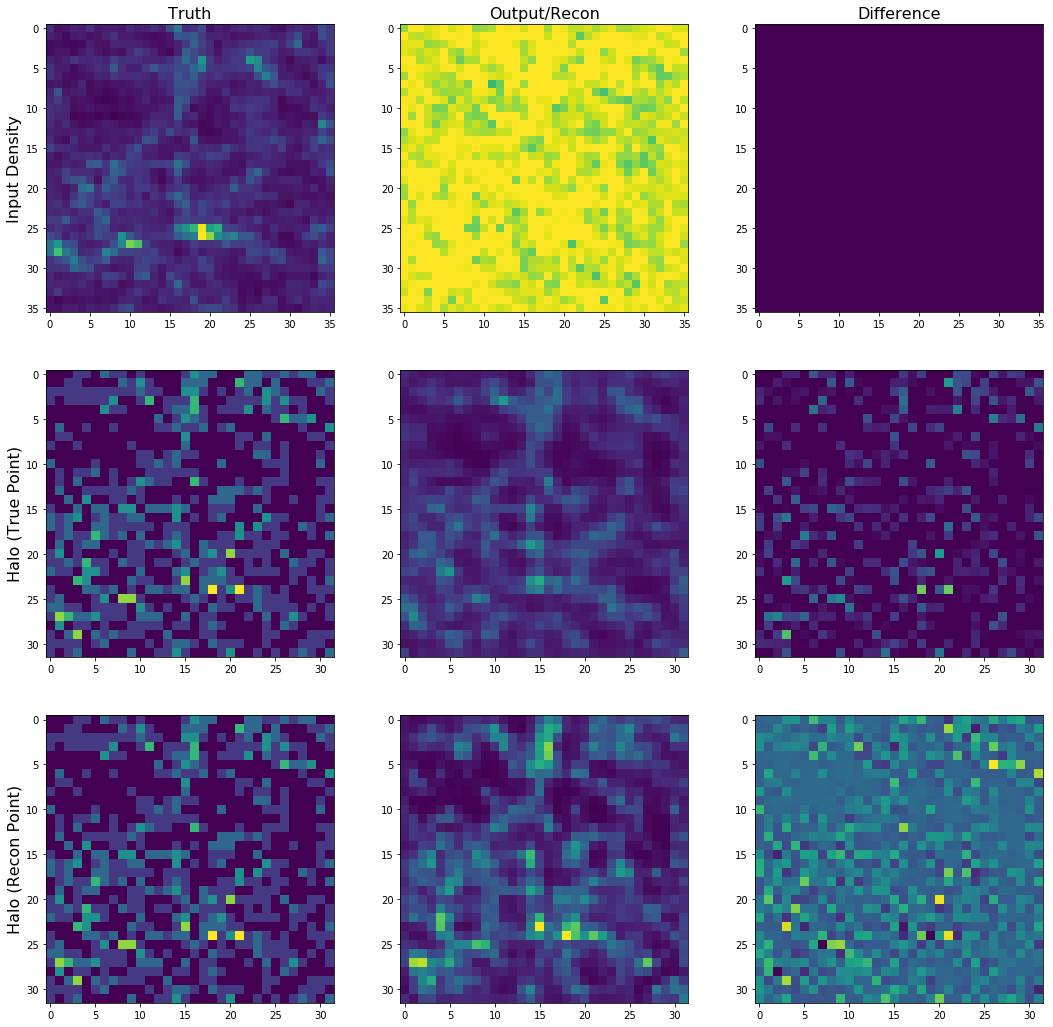

In [74]:
def getim(ar, axis=0):
    return ar[0, :, :, :, 0].sum(axis=axis)

fig, axar = plt.subplots(3, 3, figsize=(18, 18))

fsize = 16
ax = axar[0]
vmin, vmax = getim(recontruth).min(), getim(recontruth).max()
ax[0].imshow(getim(recontruth), vmin=vmin, vmax=vmax)
ax[1].imshow(getim(recon), vmin=vmin, vmax=vmax)
ax[2].imshow(getim(recontruth-recon), vmin=vmin, vmax=vmax)
ax[0].set_ylabel('Input Density', fontsize=fsize)
ax[0].set_title('Truth', fontsize=fsize)
ax[1].set_title('Output/Recon', fontsize=fsize)
ax[2].set_title('Difference', fontsize=fsize)

ax = axar[1]
vmin, vmax = getim(reconmapp).min(), getim(reconmapp).max()
ax[0].imshow(getim(reconmapp), vmin=vmin, vmax=vmax)
ax[1].imshow(getim(outtruth), vmin=vmin, vmax=vmax)
ax[2].imshow(getim(reconmapp-outtruth), vmin=vmin, vmax=vmax)
ax[0].set_ylabel('Halo (True Point)', fontsize=fsize)

ax = axar[2]
# vmin, vmax = getim(reconmapp).min(), getim(reconmapp).max()
vmin, vmax = None, None
ax[0].imshow(getim(reconmapp), vmin=vmin, vmax=vmax)
ax[1].imshow(getim(outrecon), vmin=vmin, vmax=vmax)
ax[2].imshow(getim(reconmapp-outrecon), vmin=vmin, vmax=vmax)
ax[0].set_ylabel('Halo (Recon Point)', fontsize=fsize)



# PM

In [13]:
def pm(config, verbose=False):
    g = tf.Graph()
    with g.as_default():
        linear = tfpm.linfield(config, name='linear')
        icstate = tfpm.lptinit(linear, config, name='icstate')
        fnstate = tfpm.nbody(icstate, config, verbose=verbose, name='fnstate')
        final = tf.zeros_like(linear)
        final = tfpf.cic_paint(final, fnstate[0], boxsize=bs, name='final')
        tf.add_to_collection('pm', [linear, icstate, fnstate, final])
    return g


# #Generate DATA

# pkfile = '../code/flowpm/Planck15_a1p00.txt'
# config = Config(bs=100, nc=32, seed=100, pkfile=pkfile)
# bs, nc = config['boxsize'], config['nc']


# tf.reset_default_graph()

# g = pm(config)


# with tf.Session(graph = g) as sess:
#     sess.run(tf.global_variables_initializer())
#     linear = g.get_tensor_by_name('linear:0')
#     final = g.get_tensor_by_name('final:0')
#     truth, data = sess.run([linear, final])

    
# sigma = 0.01**0.5
# np.random.seed(100)
# noise = np.random.normal(loc=0, scale=sigma, size=nc**3).reshape(nc, nc, nc).astype(config['dtype'])
# datan = data + noise



## Scipy LBFGS recon

In [178]:
tf.reset_default_graph()


def reconmodel(config, modpath, data, sigma=0.01**0.5, maxiter=100):

    bs, nc = config['boxsize'], config['nc']
    print(bs, nc)
    kmesh = sum(kk**2 for kk in config['kvec'])**0.5
    priorwt = config['ipklin'](kmesh) * bs ** -3 
    
    g = tf.Graph()

    with g.as_default():
        
        module = hub.Module(modpath)
        initlin = tf.placeholder(tf.float32, ( cube_sizeft, cube_sizeft, cube_sizeft), name='initlin')
        linear = tf.get_variable('linmesh', shape=(nc, nc, nc), 
                             initializer=tf.random_normal_initializer(mean=1.0, stddev=0.5), trainable=True)
#         linear = tf.get_variable('linmesh', shape=(nc, nc, nc), 
#                              initializer=tf.initializers.ones(), trainable=True)
        initlin_op = linear.assign(initlin, name='initlin_op')
        #PM
        icstate = tfpm.lptinit(linear, config, name='icstate')
        fnstate = tfpm.nbody(icstate, config, verbose=False, name='fnstate')
        final = tf.zeros_like(linear)
        final = tfpf.cic_paint(final, fnstate[0], boxsize=bs, name='final')
        #
    
        xx = tf.reshape(final, shape=[-1, cube_sizeft, cube_sizeft, cube_sizeft, nchannels], name='input')
        #Halos
#         yy = tf.reshape(data, shape=[-1, cube_size, cube_size, cube_size, 1], name='labels')
        yy = data
        output = module(dict(input=tf.cast(xx, tf.float32), label=tf.cast(yy, tf.float32), keepprob=1), 
                           as_dict=True)['prediction']
        prediction = tf.identity(output, name='prediction')
        #To optimize                                                                                                                       
        chisq = tf.losses.sigmoid_cross_entropy(yy, prediction)

        
        #Prior
        lineark = tfpf.r2c3d(linear, norm=nc**3)
        priormesh = tf.square(tf.cast(tf.abs(lineark), tf.float32))
        prior = tf.reduce_sum(tf.multiply(priormesh, 1/priorwt))
        prior = tf.multiply(prior, 1/nc**3, name='prior')
#         prior = tf.multiply(prior, 1, name='prior')

        #
        loss = tf.add(chisq, prior, name='loss')
        
#         optimizer = ScipyOptimizerInterface(loss, var_list=[linear], method='CG', options={'maxiter': maxiter})
        optimizer = ScipyOptimizerInterface(loss, var_list=[linear], options={'maxiter': maxiter})
        
        tf.add_to_collection('inits', [initlin_op, initlin])
        tf.add_to_collection('opt', optimizer)
        tf.add_to_collection('diagnostics', [prior, chisq, loss])
        tf.add_to_collection('reconpm', [linear, final, prediction])
        tf.add_to_collection('data', data)
    return g
    



In [179]:
#Select data voxel
ind = np.random.randint(100)
ind = 0
inp, yinp = meshes[seed][0]['inp'], meshes[seed][0]['yinp']
print('Index = %d'%ind)
recontruth = inp[ind:ind+1]
reconmapp = yinp[ind:ind+1]
####################################

pkfile = '../code/flowpm/Planck15_a1p00.txt'
config = Config(bs=400./128*cube_sizeft, nc=cube_sizeft, seed=999, pkfile=pkfile)
bs, nc = config['boxsize'], config['nc']

modpath = './models/n%02d/%s/%s.hub'%(numd*1e4, suff, chkname)

reconh = reconmodel(config, modpath, reconmapp, maxiter=100)



Index = 0
112.5 36
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [180]:
losses = []
def call_loss(l):
#     if len(losses) % (niter//10) == 0: print(l)
    print(l)
    losses.append(l)

    
with tf.Session(graph=reconh) as session:
    g = session.graph
    session.run(tf.global_variables_initializer())
    linmesh = g.get_tensor_by_name("linmesh:0")
    finmesh = g.get_tensor_by_name("final:0")
    hmesh = g.get_tensor_by_name("prediction:0")#reconh.get_collection_ref('reconpm')[0][-1]
    optimizer = g.get_collection_ref('opt')[0]
    loss = g.get_tensor_by_name('loss:0')
    prior = g.get_tensor_by_name('prior:0')

    init = session.run(linmesh)
    optimizer.minimize(session, loss_callback=call_loss, fetches=[[loss, prior]])
    print(session.run([loss, prior]))
    recon = session.run(linmesh)
    frecon = session.run(finmesh)
    hrecon = session.run(hmesh)


[58.963978, 58.26618]
[58.427803, 57.730003]
[56.30784, 55.61005]
[48.225376, 47.527622]
[22.253529, 21.555918]
[0.8106462, 0.11366287]
[0.8079215, 0.11122075]
[0.7976907, 0.101772964]
[0.71562374, 0.0168298]
[0.72533506, 0.025496924]
[0.7109458, 0.015325575]
[0.7062781, 0.011212421]
[0.7018721, 0.007341858]
[0.69828844, 0.003805536]
[0.6966243, 0.00230253]
[0.69573164, 0.0016039675]
[0.69512904, 0.0011442943]
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.695129
  Number of iterations: 11
  Number of functions evaluations: 17
[0.69512904, 0.0011442943]


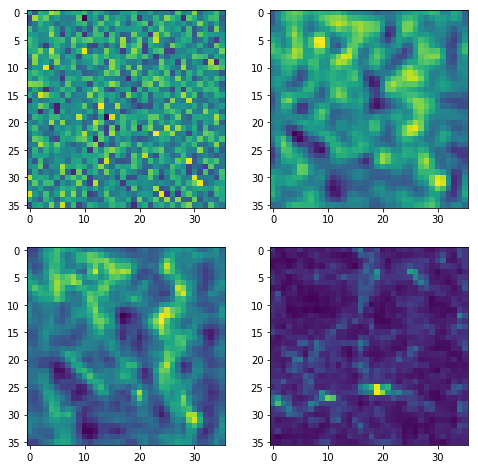

In [181]:
fig, ax = plt.subplots(2, 2, figsize = (8, 8))
ax[0, 0].imshow(init.sum(axis=0))
ax[0, 1].imshow(recon.sum(axis=0))

ax[1, 0].imshow(frecon.sum(axis=0))
ax[1, 1].imshow(recontruth[0, :, :, :, 0].sum(axis=0))

In [185]:
(hrecon>0.5).sum()

2

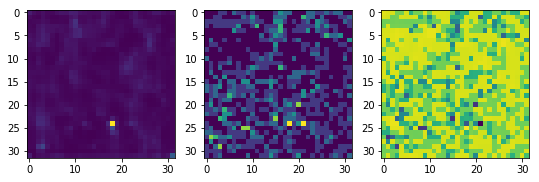

In [182]:
fig, ax = plt.subplots(1, 3, figsize = (9, 4))
ax[0].imshow(hrecon[0, :, :, :, 0].sum(axis=0))
ax[1].imshow(reconmapp[0, :, :, :, 0].sum(axis=0))
ax[2].imshow((hrecon - reconmapp)[0, :, :, :, 0].sum(axis=0))


In [127]:
# tf.reset_default_graph()
# module = hub.Module('./models/n%02d/%s/%s.hub'%(numd*1e4, suff, chkname))
# xx = tf.placeholder(tf.float32, shape=[None, cube_sizeft, cube_sizeft, cube_sizeft, nchannels], name='input')
# yy = tf.placeholder(tf.float32, shape=[None, cube_size, cube_size, cube_size, 1], name='labels')
# output = module(dict(input=xx, label=yy, keepprob=1), as_dict=True)['prediction']

# with tf.Session() as sess:
#     sess.run(tf.initializers.global_variables())
        
#     for seed in seeds:
#         inp, yinp = meshes[seed][0]['inp'], meshes[seed][0]['yinp']
#         recp = sess.run(output, feed_dict={xx:frecon.reshape(1, cube_sizeft, cube_sizeft, cube_sizeft, 1),
#                                            yy:reconmapp})
        


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


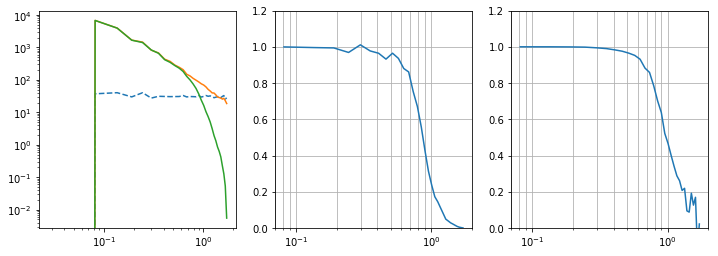

In [74]:
k, pt = tools.power(1+truth, boxsize=bs)
k, pi = tools.power(1+initscp, boxsize=bs)
k, pr = tools.power(1+reconscp, boxsize=bs)
k, px = tools.power(1+truth, 1+reconscp, boxsize=bs)

fig, ax = plt.subplots(1, 3, figsize = (12, 4))
ax[0].plot(k, pi, '--')
ax[0].plot(k, pt)
ax[0].plot(k, pr)
ax[0].loglog()

ax[1].plot(k, pr/pt)
ax[2].plot(k, px/(pr*pt)**.5)
for axis in ax[1:]: 
    axis.set_xscale('log')
    axis.set_ylim(0.0, 1.2)
    axis.grid(which='both')


In [86]:
###Initialize
# initval = np.ones_like(datan, dtype=config['dtype'])
initval = reconscp2.copy()

with tf.Session(graph=recong) as session:
    g = session.graph
    session.run(tf.global_variables_initializer())
    linmesh = g.get_tensor_by_name("linmesh:0")
    optimizer = g.get_collection_ref('opt')[0]
    loss = g.get_tensor_by_name('loss:0')
    chisq = g.get_tensor_by_name('chisq:0')
    prior = g.get_tensor_by_name('prior:0')

    if initval is not None:
        print('Do init')
        initlinop = g.get_operation_by_name('initlin_op')
        initlin = g.get_tensor_by_name('initlin:0')
        session.run(initlinop, {initlin:initval})
        
    initscp2 = session.run(linmesh)
    optimizer.minimize(session, loss_callback=call_loss, fetches=[[loss, chisq, prior]])
    reconscp2 = session.run(linmesh)
    



Do init
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1.004951
  Number of iterations: 13
  Number of functions evaluations: 52


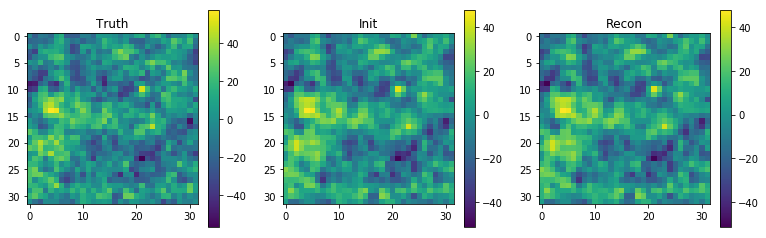

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


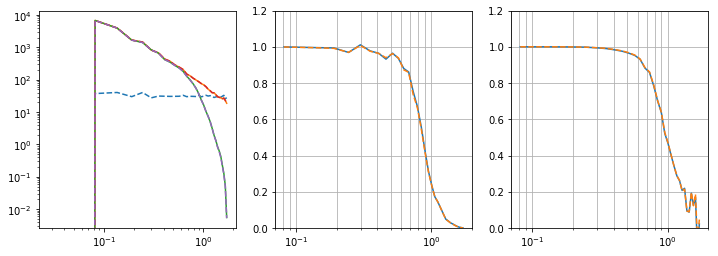

In [87]:
fig, ax = plt.subplots(1, 3, figsize = (13, 4))
im = ax[0].imshow(truth.sum(axis=0))
plt.colorbar(im, ax=ax[0])
ax[0].set_title('Truth')
im = ax[1].imshow(initscp2.sum(axis=0))
plt.colorbar(im, ax=ax[1])
ax[1].set_title('Init')
im = ax[2].imshow(reconscp2.sum(axis=0))
plt.colorbar(im, ax=ax[2])
ax[2].set_title('Recon')
plt.show()


k, pt = tools.power(1+truth, boxsize=bs)
k, pi = tools.power(1+initscp, boxsize=bs)
k, pr = tools.power(1+reconscp, boxsize=bs)
k, px = tools.power(1+truth, 1+reconscp, boxsize=bs)

fig, ax = plt.subplots(1, 3, figsize = (12, 4))
ax[0].plot(k, pi, '--')
ax[0].plot(k, pt)
ax[0].plot(k, pr)
ax[0].loglog()
ax[1].plot(k, pr/pt)
ax[2].plot(k, px/(pr*pt)**.5)

k, pt = tools.power(1+truth, boxsize=bs)
k, pi = tools.power(1+initscp2, boxsize=bs)
k, pr = tools.power(1+reconscp2, boxsize=bs)
k, px = tools.power(1+truth, 1+reconscp2, boxsize=bs)

ax[0].plot(k, pt, '--')
ax[0].plot(k, pr, '--')
ax[0].loglog()

ax[1].plot(k, pr/pt, '--')
ax[2].plot(k, px/(pr*pt)**.5, '--')
for axis in ax[1:]: 
    axis.set_xscale('log')
    axis.set_ylim(0.0, 1.2)
    axis.grid(which='both')


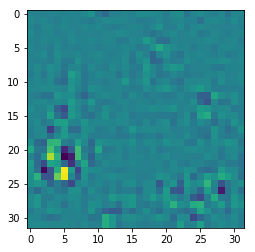

In [88]:
plt.imshow((reconscp - reconscp2).sum(axis=0))

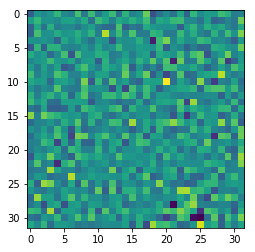

In [89]:
plt.imshow((reconscp2 - truth).sum(axis=0))

# Recon Halos

In [90]:
tf.reset_default_graph()

#                                                                                                                                           
niter = 9000
sess = tf.Session()
chkname = suff #+'_it%d'%niter                                                                                                              

path_savedat = './models/n%02d/%s/%s.hub'%(numd*1e4, suff, suff)
# saver = tf.train.import_meta_graph('./../code/models/n%02d/%s/%s.meta'%(numd*1e4, suff, chkname))


tf.reset_default_graph()
module = hub.Module('./models/n%02d/%s/%s.hub'%(numd*1e4, suff, chkname))
xx = tf.placeholder(tf.float32, shape=[None, cube_sizeft, cube_sizeft, cube_sizeft, nchannels], name='input')
yy = tf.placeholder(tf.float32, shape=[None, cube_size, cube_size, cube_size, 1], name='labels')
output = module(dict(input=xx, label=yy, keepprob=1), as_dict=True)['prediction']

with tf.Session() as sess:
    sess.run(tf.initializers.global_variables())
        
    for seed in seeds:
        inp, yinp = meshes[seed][0]['inp'], meshes[seed][0]['yinp']
        recp = sess.run(output, feed_dict={xx:inp, yy:yinp})
        meshes[seed][0]['predict'] = dtools.uncubify(recp[:,:,:,:,0], shape)

        
        

NameError: name 'suff' is not defined

In [91]:
kk = tools.fftk(shape, bs)
kmesh = sum(i**2 for i in kk)**0.5


fig, ax = plt.subplots(1, 2, figsize = (10, 4))
for seed in seeds:
    predict, hpmeshd = meshes[seed][0]['predict'], meshes[seed][1]['target'],
    k, pkpred = tools.power(predict/predict.mean(), boxsize=bs, k=kmesh)
    k, pkhd = tools.power(hpmeshd/hpmeshd.mean(), boxsize=bs, k=kmesh)
    k, pkhx = tools.power(hpmeshd/hpmeshd.mean(), predict/predict.mean(), boxsize=bs, k=kmesh)
    #k, pkpredall = tools.power(predictall/predictall.mean(), boxsize=bs, k=kmesh)                                                          
    #k, pkhallx = tools.power(hpmeshd/hpmeshd.mean(), predictall/predictall.mean(), boxsize=bs, k=kmesh)                                    

    ##                                                                                                                                      
    ax[0].semilogx(k, pkpred/pkhd, label=seed)
    ax[1].semilogx(k, pkhx/(pkpred*pkhd)**0.5)
    # plt.plot(k, pkpredall/pkhd)                                                                                                           

ax[0].legend(fontsize=14)
ax[0].set_title('Trasnfer function', fontsize=14)
ax[1].set_title('Cross correlation', fontsize=14)
for axis in ax: axis.set_ylim(0., 1.1)
for axis in ax: axis.set_yticks(np.arange(0, 1.1, 0.1))
for axis in ax: axis.grid(which='both')


NameError: name 'shape' is not defined

# Check

In [ ]:
plt.subplots()

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


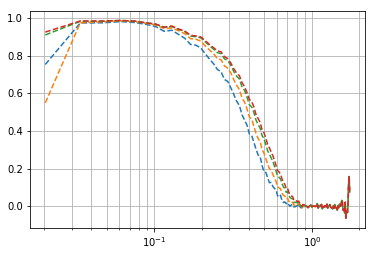

In [14]:
infolder = '../code/recon/L0400_N0128_S0100//'
bs, nc = 400, 128
truemesh = np.load(infolder + 'linear.f4.npy')
k, pt = tools.power(1+truemesh, boxsize=bs)
for j, it in enumerate([1000, 2000, 4000, 7000]):
    reconmesh = np.load(infolder + 'recon_%04d.f4.npy'%it)

    k, pr = tools.power(1+reconmesh, boxsize=bs)
    k, px = tools.power(1+truemesh, 1+reconmesh, boxsize=bs)
#     plt.plot(k, pr/pt, 'C%d'%j)
    plt.plot(k, px/(pr*pt)**.5, 'C%d--'%j)
plt.xscale('log')
# plt.ylim(0.5, 1.5)
plt.grid(which='both')

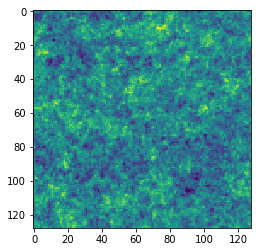

In [11]:
plt.imshow(truemesh.sum(axis=0))

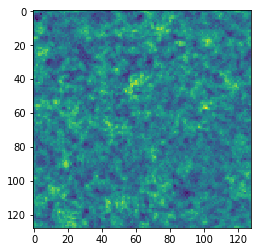

In [12]:
plt.imshow(reconmesh.sum(axis=0))

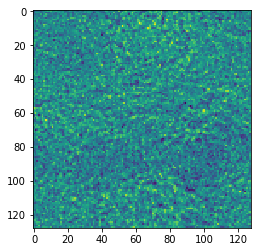

In [13]:
plt.imshow((truemesh-reconmesh).sum(axis=0))

# Profile

In [5]:
# # Create options to profile the time and memory information.
# builder = tf.profiler.ProfileOptionBuilder
# opts = builder(builder.time_and_memory()).order_by('micros').build()
# # Create a profiling context, set constructor argument `trace_steps`,
# # `dump_steps` to empty for explicit control.
# with tf.contrib.tfprof.ProfileContext('./tmp/train_dir',
#                                       trace_steps=[],
#                                       dump_steps=[]) as pctx:
#     with tf.Session(graph=g) as sess:
#         # Enable tracing for next session.run.
#         pctx.trace_next_step()
#         # Dump the profile to '/tmp/train_dir' after the step.
#         pctx.dump_next_step()
#         _ = sess.run(g.get_tensor_by_name('res:0'))
#         pctx.profiler.profile_operations(options=opts)

In [ ]:
# import tensorflow as tf
# from tensorflow.python.client import timeline

# def model():
#     g = tf.Graph()
#     with g.as_default():
#         a = tf.random_normal([20, 50])
#         b = tf.random_normal([50, 10])
#         res = tf.matmul(a, b, name='res')
#     return g

# g = model()

# tmp = tf.profiler.profile(g, cmd='op')
# # with tf.Session() as sess:
# #     # add additional options to trace the session execution
# #     options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
# #     run_metadata = tf.RunMetadata()
# #     sess.run(res, options=options, run_metadata=run_metadata)

# #     # Create the Timeline object, and write it to a json file
# #     fetched_timeline = timeline.Timeline(run_metadata.step_stats)
# #     chrome_trace = fetched_timeline.generate_chrome_trace_format()
# #     with open('timeline_01.json', 'w') as f:
# #         f.write(chrome_trace)

In [41]:
# pkfile = '../code/flowpm/Planck15_a1p00.txt'
# config = Config(bs=100, nc=32, seed=100, stages = np.linspace(0.01, 1, 3), pkfile=pkfile)
# bs, nc = config['boxsize'], config['nc']
# grid = bs/nc*np.indices((nc, nc, nc)).reshape(3, -1).T.astype(np.float32)

# tf.reset_default_graph()
# def flowpm(config):
#     g = tf.Graph()
#     with g.as_default():
#         linear = tfpm.linfield(config)
#         lineark = tfpf.r2c3d(linear, config)
#         icstate = tfpm.lptinit(lineark, grid, config)
#         fnstate = tfpm.nbody(icstate, config, verbose=False)
#         final = tf.zeros_like(linear)
#         final = tfpf.cic_paint(final, fnstate[0], boxsize=bs)
#     return g

# pmgraph = flowpm(config)

In [118]:
pkfile = '../code/flowpm/Planck15_a1p00.txt'
# config = Config(bs=100, nc=128, seed=100, stages = np.linspace(0.01, 1, 3), pkfile=pkfile)
config = Config(bs=100, nc=32, seed=100, pkfile=pkfile)
bs, nc = config['boxsize'], config['nc']
grid = bs/nc*np.indices((nc, nc, nc)).reshape(3, -1).T.astype(np.float32)

tf.reset_default_graph()
linear = tfpm.linfield(config)
lineark = tfpf.r2c3d(linear)
icstate = tfpm.lptinit(lineark, grid, config)
fnstate = tfpm.nbody(icstate, config, verbose=False)
final = tf.zeros_like(linear)
final = tfpf.cic_paint(final, fnstate[0], boxsize=bs)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    linmesh, fstate, mesh = sess.run([linear, fnstate, final])


In [6]:
from time import time

In [55]:
%timeit tfpf.laplace(config)
%timeit tfpf.laplace2(config)
%timeit tfpf.gradient(config, 1)

19.9 ms ± 3.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
18.4 ms ± 3.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
18 µs ± 1.14 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [7]:
ic[0]

array([[ 4.7943942e-02, -1.7028974e-03,  6.7412019e-02],
       [ 4.3343827e-02, -7.0656775e-03,  3.1618800e+00],
       [ 6.9417059e-02, -7.3283422e-03,  6.2857866e+00],
       ...,
       [ 9.6902298e+01,  9.6875732e+01,  9.0616890e+01],
       [ 9.6874756e+01,  9.6856544e+01,  9.3798386e+01],
       [ 9.6868729e+01,  9.6846260e+01,  9.6938789e+01]], dtype=float32)

In [80]:
tf.reset_default_graph()

niter = 20 

tmesh = tf.zeros_like(mesh)
tpart = tf.Variable(0.)
tpart = tf.assign(tpart, ic[0], validate_shape=False)
result = tfpf.cic_paint(tmesh, tpart,  boxsize=bs)

times = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    totstart = time()
    for _ in range(niter):
        start = time()
        sess.run(result)
        end = time()
        times.append(end - start)
    totend = time()
print('Time taken for CIC - ', end - start, (totend-totstart)/niter)
np.array(times).mean(), np.array(times[1:]).mean()

Time taken for CIC -  0.11084651947021484 0.09658712148666382


(0.09658359289169312, 0.0800266140385678)

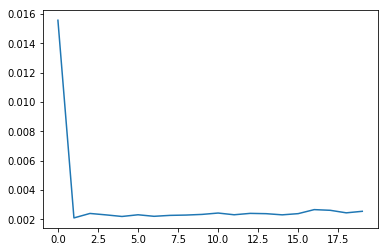

In [47]:
# plt.hist(times)
plt.plot(times)

In [48]:
tf.reset_default_graph()

tmesh = tf.zeros_like(mesh)
tpart = tf.Variable(0.)
tpart = tf.assign(tpart, ic[0], validate_shape=False)
result = tfpf.cic_readout(tmesh, tpart, boxsize=bs)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    start = time()
    for _ in range(niter):
        sess.run(result)
    end = time()
    print(end - start, (end-start)/niter)
print('Time taken for 100 readouts - ', end - start, (end-start)/niter)

0.06261467933654785 0.0031307339668273926
Time taken for 100 readouts -  0.06261467933654785 0.0031307339668273926


In [23]:
tf.reset_default_graph()

tmesh = tf.zeros_like(mesh)
tpart = tf.Variable(0.)
tpart = tf.assign(tpart, ic[0], validate_shape=False)
result = tfpf.cic_readout(tmesh, tpart, boxsize=bs)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    start = time()
    for _ in range(niter):
        sess.run(result)
    end = time()
    print(end - start, (end-start)/niter)
print('Time taken for 100 readouts - ', end - start, (end-start)/niter)

6.238195419311523 0.31190977096557615
Time taken for 100 readouts -  6.238195419311523 0.31190977096557615


In [88]:
tf.reset_default_graph()

tmesh = tf.zeros_like(mesh)
# tmesh = tf.cast(tmesh, tf.complex64)
result = tfpf.r2c3d(tmesh, config)

times = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    totstart = time()
    for _ in range(niter):
        start = time()
        sess.run(result)
        end = time()
        times.append(end - start)
    totend = time()
print('Time taken for r2c - ', end - start, (totend-totstart)/niter)

Time taken for r2c -  0.002713918685913086 0.03318428993225098


In [89]:
tf.reset_default_graph()

tmesh = tf.zeros_like(mesh)
# tmesh = tf.cast(tmesh, tf.complex64)
result = tfpf.r2c3d2(tmesh)

times = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    totstart = time()
    for _ in range(niter):
        start = time()
        sess.run(result)
        end = time()
        times.append(end - start)
    totend = time()
print('Time taken for r2c - ', end - start, (totend-totstart)/niter)

Time taken for r2c -  0.0028395652770996094 0.033509790897369385


In [90]:
tf.reset_default_graph()

tmesh = tf.zeros_like(mesh)
# tmesh = tf.cast(tmesh, tf.complex64)
result = tfpf.r2c3d2(tmesh, nc**3)

times = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    totstart = time()
    for _ in range(niter):
        start = time()
        sess.run(result)
        end = time()
        times.append(end - start)
    totend = time()
print('Time taken for r2c - ', end - start, (totend-totstart)/niter)

Time taken for r2c -  0.0026197433471679688 0.03126882314682007


In [25]:
tf.reset_default_graph()

tmesh = tf.zeros_like(mesh, dtype=tf.complex64)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    start = time()
    for _ in range(niter):
        sess.run(tfpf.c2r3d(tmesh, config))
    end = time()
    print(end - start, (end-start)/niter)
print('Time taken for 100 c2r - ', end - start, (end-start)/niter)

12.759227991104126 0.6379613995552063
Time taken for 100 c2r -  12.759227991104126 0.6379613995552063


N = 32, CIC = 0.166, r2c = 0.018

N = 64, CIC = 0.8, r2c = 0.07

# BFGS

In [19]:
import tensorflow_probability as tfp

In [20]:
minimum = np.array([1.0, 1.0])  # The center of the quadratic bowl.
scales = np.array([2.0, 3.0])  # The scales along the two axes.

# The objective function and the gradient.
def quadratic(x):
    value = tf.reduce_sum(scales * (x - minimum) ** 2)
    return value, tf.gradients(value, x)[0]

start = tf.constant([0.6, 0.8])  # Starting point for the search.
optim_results = tfp.optimizer.bfgs_minimize(quadratic, initial_position=start, tolerance=1e-8)

with tf.Session() as session:
    results = session.run(optim_results)
    # Check that the search converged
    assert(results.converged)
    # Check that the argmin is close to the actual value.
    np.testing.assert_allclose(results.position, minimum)
    # Print out the total number of function evaluations it took. Should be 6.
    print ("Function evaluations: %d" % results.num_objective_evaluations)


Function evaluations: 6


In [23]:
results.position


array([1., 1.], dtype=float32)

# Scipy

In [40]:
from tensorflow.contrib.opt import ScipyOptimizerInterface 

In [69]:
tf.reset_default_graph()

vector = tf.get_variable('vector', 2, initializer=tf.random_normal_initializer())
toadd = tf.Variable([1., 5])
# Make vector norm as small as possible.
loss = tf.reduce_sum(tf.square(tf.add(vector, toadd)))

optimizer = ScipyOptimizerInterface(loss, var_list=[vector],  method='L-BFGS-B', options={'maxiter': 5})

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    optimizer.minimize(session)
    print(session.run([vector, toadd]))
# The value of vector should now be [0., 0.].


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.000000
  Number of iterations: 2
  Number of functions evaluations: 3
[array([-1.0000001, -5.       ], dtype=float32), array([1., 5.], dtype=float32)]


In [58]:
optimizer.optimizer_kwargs

{'method': 'L-BFGS-B', 'options': {'maxiter': 100}}